# Score LDL variants for the HepG2 task
Look for variants that increase / decrease expression to explain mechanisms of disease, find causal variants, and predict the most pathogenic variants. Also a validation technique.

1. make bed file with appropriate regions
2. bedtools getfasta for the sequences
3. intialize model
4. convert to one hot
5. try all base pair changes (ISM)
6. compute deepLIFT scores

In [1]:
import os

basePath = '../../data/variants/peyton_gwas/expanded_LD_geno/rsq_0.8/grasp/'
phenotype = 'LDL_cholesterol'
os.system('mkdir ../variant_scoring/%s' % phenotype)
variantBed = open(basePath + phenotype + '_pruned_rsq_0.8_expanded_rsq_0.8.bed')
variantSequenceBed = open('../variant_scoring/%s/variants_sequence_context.bed' % phenotype, 'w')
associatedVariants = []
for line in variantBed:
    line = line.strip().split('\t')
    line[1] = str(int(line[1]) - 72)
    line[2] = str(int(line[2]) + 72)
    associatedVariants.append(line[3])
    variantSequenceBed.write('\t'.join(line) + '\n')
variantBed.close()
variantSequenceBed.close()

In [4]:
!bedtools getfasta -fi /scratch/users/rmovva/data/hg19.fa -bed ../variant_scoring/LDL_cholesterol/variants_sequence_context.bed -fo ../variant_scoring/LDL_cholesterol/variant_sequences.fa

In [2]:
import avutils.util
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np

modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

seqNames = []
seqStrings = []
with open('../variant_scoring/%s/variant_sequences.fa' % phenotype) as seqFile:
    i = 0
    for line in seqFile:
        line = line.strip()
        if i % 2 == 0:
            seqNames.append(line.split('>')[1] + ',' + associatedVariants[i/2])
        else:
            seqStrings.append(line)
        i += 1

import time
t0 = time.time()
seqs = np.array([avutils.util.seq_to_one_hot(seq) for seq in seqStrings]).astype(np.float32)
print("Converting seq strings to one-hot arrays took %.3f sec" % (time.time() - t0))
print seqs.shape

/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:82:00.0)
Using Theano backend.


Converting seq strings to one-hot arrays took 46.111 sec
(1003711, 145, 4)


In [3]:
seqs = seqs.astype(np.float32)
seqsMutated = np.ndarray(shape=(4, seqs.shape[0], seqs.shape[1], seqs.shape[2]), dtype=np.float32)
for i in range(4):
    seqs[:, seqs.shape[1]/2] = np.zeros(4)
    seqs[:, seqs.shape[1]/2, i] = 1.0
    seqsMutated[i] = seqs

In [4]:
print seqs[0][72]
print seqsMutated[:, 0, 72, :]

[ 0.  0.  0.  1.]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [5]:
t0 = time.time()
refPreds = keras_model.predict(seqs, batch_size=200)
print("Computing reference predictions took %.3f sec" % (time.time() - t0))

Computing reference predictions took 89.457 sec


In [6]:
mutPreds = np.ndarray(shape=(4, seqs.shape[0], refPreds.shape[1]), dtype=np.float32)
t0 = time.time()
for i in range(len(mutPreds)):
    mutPreds[i] = keras_model.predict(seqsMutated[i], batch_size=200)
print("Computing mutated predictions took %.3f sec" % (time.time() - t0))

Computing mutated predictions took 139.007 sec


In [27]:
np.save("../variant_scoring/LDL_cholesterol/refPreds.npy",
        refPreds)
np.save("../variant_scoring/LDL_cholesterol/mutPreds.npy",
        mutPreds)

In [20]:
# hepg2_scores = np.max(np.abs(np.log2(mutPreds[:, :, 8]) - np.log2(refPreds[:, 8])), axis=0)
# k562_scores = np.max(np.abs(np.log2(mutPreds[:, :, 2]) - np.log2(refPreds[:, 2])), axis=0)
# hepg2_scores = np.log2(np.max(np.abs((mutPreds[:, :, 8] - refPreds[:, 8]) / refPreds[:, 8]), axis=0))
# k562_scores = np.log2(np.max(np.abs((mutPreds[:, :, 2] - refPreds[:, 2]) / refPreds[:, 2]), axis=0))
hepg2_scores = np.max(np.abs(mutPreds[:, :, 8] - refPreds[:, 8]), axis=0)
k562_scores = np.max(np.abs(mutPreds[:, :, 2] - refPreds[:, 2]), axis=0)
# hepg2_scores = np.max(np.abs(mutPreds[:, :, 11] - refPreds[:, 11]), axis=0)
# k562_scores = np.max(np.abs(mutPreds[:, :, 5] - refPreds[:, 5]), axis=0)

In [21]:
hepg2ScoresByTagSnp = {snp: [] for snp in set(associatedVariants)}
k562ScoresByTagSnp = {snp: [] for snp in set(associatedVariants)}
for (i, score) in enumerate(hepg2_scores):
    hepg2ScoresByTagSnp[associatedVariants[i]].append(hepg2_scores[i])
    k562ScoresByTagSnp[associatedVariants[i]].append(k562_scores[i])
hepg2MaxScoresByTagSnp = {snp: np.max(hepg2ScoresByTagSnp[snp]) for snp in hepg2ScoresByTagSnp}
k562MaxScoresByTagSnp = {snp: np.max(k562ScoresByTagSnp[snp]) for snp in k562ScoresByTagSnp}
hepg2SecondScoresByTagSnp = {snp: hepg2ScoresByTagSnp[snp][0] if len(hepg2ScoresByTagSnp[snp]) == 1 else np.sort(hepg2ScoresByTagSnp[snp])[::-1][1] for snp in hepg2ScoresByTagSnp}
k562SecondScoresByTagSnp = {snp: k562ScoresByTagSnp[snp][0] if len(k562ScoresByTagSnp[snp]) == 1 else np.sort(k562ScoresByTagSnp[snp])[::-1][1] for snp in k562ScoresByTagSnp}

In [22]:
print np.mean(hepg2_scores), np.std(hepg2_scores)
print np.mean(k562_scores), np.std(k562_scores)
print np.mean(hepg2MaxScoresByTagSnp.values()), np.std(hepg2MaxScoresByTagSnp.values())
print np.mean(k562MaxScoresByTagSnp.values()), np.std(k562MaxScoresByTagSnp.values())
hepg2Ratios = np.array(hepg2MaxScoresByTagSnp.values()) / np.array(hepg2SecondScoresByTagSnp.values())
k562Ratios = np.array(k562MaxScoresByTagSnp.values()) / np.array(k562SecondScoresByTagSnp.values())
print np.mean(hepg2Ratios), np.std(hepg2Ratios)
print np.mean(k562Ratios), np.std(k562Ratios)

0.04938 0.0425464
0.0619959 0.0434637
0.103606 0.0946029
0.116271 0.0908191
1.53261 1.30825
1.42252 0.942196


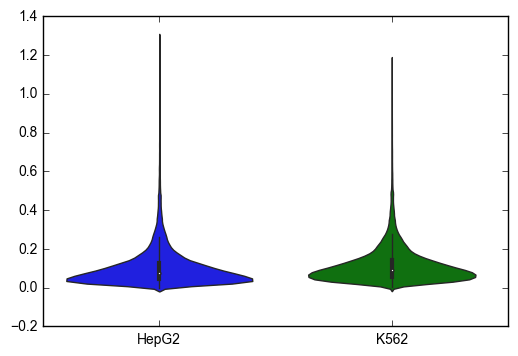

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_dict = {'HepG2': hepg2MaxScoresByTagSnp.values(), 'K562': k562MaxScoresByTagSnp.values()}
df = pd.DataFrame.from_dict(df_dict)

# sns.boxplot(data=df, showfliers=True)
sns.violinplot(data=df, showfliers=True)

plt.show()

In [131]:
print "HepG2"
print np.sort(hepg2_scores)[::-1][:10]
print np.argsort(hepg2_scores)[::-1][:10]
print np.sort(hepg2_scores)[:10]
print np.argsort(hepg2_scores)[:10]
print "K562"
print np.sort(k562_scores)[::-1][:10]
print np.argsort(k562_scores)[::-1][:10]
print np.sort(k562_scores)[:10]
print np.argsort(k562_scores)[:10]
print len(set(np.argsort(k562_scores)[::-1][:10]).intersection(np.argsort(hepg2_scores)[::-1][:10]))

HepG2
[ 1.29019952  1.20572996  1.06968939  1.04579473  1.03509963  0.97602427
  0.96438742  0.95192677  0.94532216  0.93639517]
[808722 231500 210803 621244 648508 414723 494358 631461 497844 566686]
[ 0.00023094  0.00027475  0.00048102  0.000528    0.000606    0.000606
  0.0006067   0.00060672  0.00063346  0.00067669]
[198935  87611 725309 516173 590269 590268  58069  92427 975889 730089]
K562
[ 1.17142379  1.15530252  1.01787317  0.9672491   0.95594156  0.94325411
  0.93980086  0.90893173  0.90420294  0.89360923]
[808722 231500 648508 621244 210803 497844 414723 528849 566686 494358]
[ 0.00036955  0.00052136  0.0005483   0.0006566   0.00089183  0.00104889
  0.00105584  0.00107908  0.00108552  0.00112133]
[ 50779 582144  53781  59562 469238 623531 445132 735473 822081 117239]
9


In [123]:
from scipy.stats import spearmanr

# sample = np.random.choice(np.arange(len(hepg2_scores)), 1000)

print spearmanr(k562_scores, hepg2_scores, nan_policy = 'omit')

SpearmanrResult(correlation=0.7652785229639244, pvalue=0.0)


In [127]:
variant_idxs = np.argsort(hepg2_scores)[::-1][:10]
for (i, variant_idx) in enumerate(variant_idxs):
    print(i+1)
    print hepg2_scores[variant_idx]
    print seqStrings[variant_idx]
    print seqNames[variant_idx]
    print seqStrings[variant_idx][65:80]

1
1.2902
acctggtggaatatgattgaattatggggtcaggtctttcccatgctgttctcatgatagtgaatgggtctcacgagatatgatggttttaaaaatgggagtttctctgcacaagctctctttttttgactgttgccatccatgt
chr6:84544203-84544348,rs16874003
gggtctcacgagata
2
1.20573
gtgtttgcaatgaattttaaaaCGCACATCTGggtcaggtgcggtggctcacacctgtaatcccagcacttcaggaagctgatgtgggaggatcgcttgaggccaggagttcgagacccagcctgggcaacatagtgagatactg
chr12:124410456-124410601,rs11057408
gcacttcaggaagct
3
1.06969
cccaaaagagaaaaaaacagaaaatcgactacagaatgaaaagagaaaggatgctggttcttccactcttccggaagtcactttatgcagaaaggaggagcttgccacaagtaagggaagtgcaacaacagtggccatgtttctt
chr12:55572428-55572573,rs7966464
ctcttccggaagtca
4
1.04579
tggctcttgggggtggattcctcatgaatggctctgtgttgttctctgggccgtgagtgagtttttgctctctcgagactggtttagttcttgggggaatggattagttctcactaataaaagaacaggtttttatagagaaaga
chr3:176929172-176929317,rs9290612
tgctctctcgagact
5
1.0351
ACCGTGATTTAAACATACTTCAAGAggctgggcatggtggctcacgcctgtaatcccagcactttcggaagccgaagtgggtggatcacaaggtcaggagttcaagaccagcctggccaagatggtgaaaccccatctctattaa
chr4:46264609-4626

Motifs for the top 10 matches above ALL correspond to known TFs!
1. ZBTB33
2. ELK1
3. ELK1
4. ZBTB33
5. SPI1_full
6. ELK1
7. NRF1
8. ETV6
9. GABPA
10. ELK1

# Using the Nature Genetics 2013 LDL variant set (un-LD-expanded)

In [1]:
import os

basepath = '../../data/variants/ldl_gwas/'
path = basepath + 'jointGwasMc_LDL.txt'

In [1]:
os.system('mkdir ../variant_scoring/LDL_gwasNatGenet')

with open(path) as f:
    with open(basepath + 'ldlGwasWithStatsBed4.bed', 'w') as out:
        header = f.readline()
        header = header.strip().split('\t')[2:]
        newHeader = ['chr', 'start', 'end'] + header
#         out.write('\t'.join(newHeader) + '\n')
        for line in f:
            line = line.strip().split('\t')
            stats = line[2:]
            pos = line[1]
            chrom = pos.split(':')[0]
            start, end = str(int(pos.split(':')[1]) - 72), str(int(pos.split(':')[1]) + 73)
            newLine = [chrom, start, end] + stats
            out.write('\t'.join(newLine[:4]) + '\n')

In [3]:
with open(basepath + 'ldlGwasWithStats_LdExpanded80_v2.bed') as f:
    with open(basepath + 'expanded_tagLd_regions_all.bed', 'w') as out:
        for line in f:
            line = line.strip().split('\t')
            chrom = line[0]
            start, end = str(int(line[1]) - 72), str(int(line[2]) + 72)
            variants = line[3] + ',' + line[4]
            out.write('\t'.join([chrom, start, end, variants]) + '\n')

In [5]:
!bedtools subtract -a ../../data/variants/ldl_gwas/expanded_tagLd_regions_all.bed -b ../../data/geneCoords/UCSC_canonical_hg19.bed -f 0.1 > ../../data/variants/ldl_gwas/expanded_tagLd_regions_noncoding10pct.bed 

In [6]:
!mv expanded_tagLd_regions_noncoding10pct.bed ../../data/variants/ldl_gwas/

In [152]:
from collections import OrderedDict

snpPvals = OrderedDict()

with open(path) as f:
    f.readline()
    for line in f:
        line = line.strip().split('\t')
        snpPvals[line[2]] = float(line[-2])

In [276]:
import numpy as np

useSnp = {snp: False for snp in snpPvals.keys()}

thresh = 5e-3
percentBackground = 1.0/199
# thresh = 1.1
# percentBackground = 1
cnt = 0
for (i, snp) in enumerate(useSnp.keys()):
    pval = snpPvals[snp]
#     if np.random.random() < 0.01:
#         useSnp[snp] = True
    if pval < thresh:
        useSnp[snp] = True
        cnt += 1
    elif np.random.random() < percentBackground:
        useSnp[snp] = True
        cnt += 1
print cnt

37696


In [523]:
ldBlocks = OrderedDict()
snps = []

# bedtoolsFile = open(basepath + 'expanded_all_bedtools_1m.bed', 'w')

i = 0
with open(basepath + 'expanded_tagLd_regions_all.bed') as f:
    for line in f:
#         if i >= 1000000:
#             break
        line = line.strip().split('\t')
        chrom = line[0]
#         start = str(int(line[1]) - 72)
#         end = str(int(line[2]) + 72)
        start = line[1]
        end = line[2]
        if int(end) - int(start) != 145:
            continue
#         tagSnp = line[-1]
#         ldSnp = line[-2]
        ldSnp, tagSnp = line[-1].split(',')
        if (ldSnp, tagSnp) == ('rs3923037', 'rs4426495') or (ldSnp, tagSnp) == ('rs6923877', 'rs6455689'):
            print start, end
        if useSnp[tagSnp] == False:
            continue
        if tagSnp not in ldBlocks:
            ldBlocks[tagSnp] = []
        ldBlocks[tagSnp].append(ldSnp)
#         bedtoolsFile.write('\t'.join([chrom, start, end, ldSnp]) + '\n')
        snps.append((tagSnp, ldSnp))
        i += 1

# bedtoolsFile.close()

21148201 21148346
160996724 160996869


In [279]:
print len(snps)

2025319


In [157]:
print 10**(-1*np.mean(-1*np.log10(np.array([pval+1e-8 for pval in snpPvals.values()]))))
print np.mean([len(ldBlocks[snp]) for snp in ldBlocks])

0.345343877432
33.7541348815


In [111]:
!head -5000000 ../../data/variants/ldl_gwas/expanded_all_bedtools.bed > ../../data/variants/ldl_gwas/expanded_all_bedtools_5m.bed

In [158]:
!bedtools getfasta -fi /scratch/users/rmovva/data/hg19.fa -bed ../../data/variants/ldl_gwas/expanded_all_bedtools_1m.bed -fo ../variant_scoring/LDL_gwasNatGenet/variant_sequences_expanded_all_1m.fa

In [448]:
import avutils.util
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np

modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

seqStrings = []
with open('../variant_scoring/LDL_gwasNatGenet/variant_sequences_expanded_all_5e3.fa') as seqFile:
    i = 0
    snpIdx = 0
    for line in seqFile:
        line = line.strip()
        if i % 2 == 1:
            seqStrings.append(line)
            snpIdx += 1
        i += 1

In [484]:
import time
t0 = time.time()
# N = 10000000
seqs = np.array([avutils.util.seq_to_one_hot(seq) for seq in seqStrings]).astype(np.int8)
print("Converting seq strings to one-hot arrays took %.3f sec" % (time.time() - t0))
print seqs.shape

Converting seq strings to one-hot arrays took 90.039 sec
(2024253, 145, 4)


In [485]:
t0 = time.time()
refPreds = keras_model.predict(seqs, batch_size=500)
print("Computing reference predictions took %.3f sec" % (time.time() - t0))

Computing reference predictions took 58.702 sec


In [165]:
# seqs = seqs.astype(np.float16)
seqsMutated = np.ndarray(shape=(4, seqs.shape[0], seqs.shape[1], seqs.shape[2]), dtype=np.int8)
for i in range(4):
    seqs[:, seqs.shape[1]/2] = np.zeros(4)
    seqs[:, seqs.shape[1]/2, i] = 1.0
    seqsMutated[i] = seqs

In [166]:
mutPreds = np.ndarray(shape=(4, seqs.shape[0], refPreds.shape[1]), dtype=np.float32)
t0 = time.time()
for i in range(len(mutPreds)):
    mutPreds[i] = keras_model.predict(seqsMutated[i], batch_size=500)
print("Computing mutated predictions took %.3f sec" % (time.time() - t0))

Computing reference predictions took 29.889 sec
Computing mutated predictions took 110.198 sec


In [450]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
reload(deeplift)
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence

# normalize weights
W, b = keras_model.layers[0].get_weights()
mean_W = np.mean(W, axis = -2)
W = W - mean_W[:, :, None, :]
b = b + np.squeeze(np.sum(mean_W,axis=0))
keras_model.layers[0].set_weights([W, b])

deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

deeplift_prediction_function = deeplift_model.get_prediction_function(input_layer_idx = 0,
                                                                      output_layer_idx = -1
                                                                     )

deeplift_scoring_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx = 0,
                                                                target_layer_idx = -1
                                                               )

import avutils
from deeplift.dinuc_shuffle import dinuc_shuffle

seed = 0
deeplift_many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
                                score_computation_function=deeplift_scoring_func, #supply any deeplift scoring function
                                shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
                                seed=seed,
                                one_hot_func=lambda x: np.array([avutils.util.seq_to_one_hot(seq) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                            )

task_idxs = [8] # 'average' tasks for k5minp, k5sv40, hepminp, hepsv40 respectively

task_to_deeplift_contribs = OrderedDict()
for task_idx in task_idxs:
    task_to_deeplift_contribs[task_idx] = np.array(deeplift_many_refs_func(
                                                      task_idx = task_idx,
                                                      input_data_sequences=seqStrings,
                                                      num_refs_per_seq=5,
                                                      batch_size=500,
                                                      progress_update=1000000))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 5 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
1000000 reference seqs generated
2000000 reference seqs generated
3000000 reference seqs generated
4000000 reference seqs generated
5000000 reference seqs generated
6000000 reference seqs generated
7000000 reference seqs generated
8000000 reference seqs generated
9000000 reference seqs generated
10000000 reference seqs generated
One hot 

In [451]:
task_to_deeplift_summedscores = OrderedDict()
for task_idx in task_idxs:
    summed_scores = np.sum(task_to_deeplift_contribs[task_idx], axis=2)
    task_to_deeplift_summedscores[task_idx] = np.expand_dims(summed_scores, axis=2)*seqs

In [452]:
deeplift_minp = np.abs(np.sum(task_to_deeplift_summedscores[8], axis=2)[:, 72])

In [487]:
np.save("../variant_scoring/LDL_gwasNatGenet/refPreds_all_5e3_corrected.npy",
        refPreds)
# np.save("../variant_scoring/LDL_gwasNatGenet/mutPreds_all_5e3.npy",
#         mutPreds)

In [100]:
np.save("../variant_scoring/LDL_gwasNatGenet/deepliftScores_all_5e3.npy",
        deeplift_minp)

In [378]:
deepliftScores = np.load("../variant_scoring/LDL_gwasNatGenet/deepliftScores_all_5e3.npy")

In [379]:
print deepliftScores.shape

(2024253,)


In [280]:
refPreds = np.load("../variant_scoring/LDL_gwasNatGenet/refPreds_all_5e3.npy")
mutPreds = np.load("../variant_scoring/LDL_gwasNatGenet/mutPreds_all_5e3.npy")

In [488]:
delta = mutPreds[:, :, 8] - refPreds[:, 8]
maxIndices = np.argmax(np.abs(delta), axis=0)
# signed_scores_minp = np.take(delta, maxIndices, axis=0)
signed_scores_minp = []
for (i,idx) in enumerate(maxIndices):
    signed_scores_minp.append(delta[idx, i])
signed_scores_minp = np.array(signed_scores_minp)
signed_percents = 100 * signed_scores_minp / np.abs(refPreds[:, 8])
scores_minp = np.max(np.abs(mutPreds[:, :, 8] - refPreds[:, 8]), axis=0)

In [489]:
print signed_scores_minp.shape
print signed_scores_minp[:10]
print signed_percents[:10]

(2024253,)
[ 0.02218631 -0.16143413 -0.04134776 -0.05216216  0.09580588  0.13183722
  0.05320449  0.05061182  0.05061182  0.03395439]
[ 10.36034489 -76.75145721 -17.13240623 -35.65889359  77.16714478
  33.55542755  92.1968689   52.54468536  52.54468536  23.3376503 ]


In [490]:
print scores_minp.shape
print len(snps)
print snps[0]
# print len(set([snp[0] for snp in snps]))
# print len(set([snp[1] for snp in snps]))

(2024253,)
2025319
('rs263526', 'rs192939156')


In [491]:
from collections import OrderedDict

scoresPerTagSnp = OrderedDict()
percentsPerTagSnp = OrderedDict()
ldSnpsPerTagSnp = OrderedDict()

for (i, score) in enumerate(signed_scores_minp):
    tagSnp, ldSnp = snps[i]
    if tagSnp not in scoresPerTagSnp:
        scoresPerTagSnp[tagSnp] = []
    scoresPerTagSnp[tagSnp].append(score)
    if tagSnp not in percentsPerTagSnp:
        percentsPerTagSnp[tagSnp] = []
    percentsPerTagSnp[tagSnp].append(signed_percents[i])
    if tagSnp not in ldSnpsPerTagSnp:
        ldSnpsPerTagSnp[tagSnp] = []
    ldSnpsPerTagSnp[tagSnp].append(ldSnp)

maxScorePerTagSnp = OrderedDict()
maxPercentPerTagSnp = OrderedDict()
topLdSnpPerTagSnp = OrderedDict()
for tagSnp in scoresPerTagSnp:
    maxAbsIdx = np.argmax(np.abs(np.array(scoresPerTagSnp[tagSnp])))
    maxScorePerTagSnp[tagSnp] = scoresPerTagSnp[tagSnp][maxAbsIdx]
    maxPercentAbsIdx = np.argmax(np.abs(np.array(percentsPerTagSnp[tagSnp])))
    maxPercentPerTagSnp[tagSnp] = percentsPerTagSnp[tagSnp][maxAbsIdx]
    topLdSnpPerTagSnp[tagSnp] = ldSnpsPerTagSnp[tagSnp][maxAbsIdx]

In [492]:
testedTagSnps = []
testedPvals = []
testedMaxScores = []
testedLdBlockSizes = []
testedTopLdSnps = []
testedMaxPercents = []

for snp in maxScorePerTagSnp:
    testedTopLdSnps.append(topLdSnpPerTagSnp[snp])
    testedTagSnps.append(snp)
    testedPvals.append(snpPvals[snp])
    testedMaxScores.append(maxScorePerTagSnp[snp])
    testedLdBlockSizes.append(len(scoresPerTagSnp[snp]))
    testedMaxPercents.append(maxPercentPerTagSnp[snp])
    
testedTagSnps = np.array(testedTagSnps)
testedPvals = np.array(testedPvals)
testedMaxScores = np.array(testedMaxScores)
testedLdBlockSizes = np.array(testedLdBlockSizes)
testedTopLdSnps = np.array(testedTopLdSnps)
testedMaxPercents = np.array(testedMaxPercents)

In [493]:
import scipy.stats as sp

thresh = 5e-6
sig = testedPvals < thresh
sig = np.logical_and(testedPvals < thresh, testedLdBlockSizes < 100)
notsig = testedPvals > 0.1
notsig = np.logical_and(testedPvals > 0.1, testedLdBlockSizes < 100)
# notsig = np.logical_not(sig)
# notsig = testedPvals > thresh
# notsig = testedPvals > 0.1
# sig = testedPvals < 5e-6
# notsig = testedPvals >= 0.1
print np.sum(sig)
print np.sum(notsig)
print np.mean([len(scoresPerTagSnp[snp]) for snp in testedTagSnps[sig]])
print np.mean([len(scoresPerTagSnp[snp]) for snp in testedTagSnps[notsig]])
print np.mean(np.abs(testedMaxScores[sig]))
print np.mean(np.abs(testedMaxScores[notsig]))
print np.median(np.abs(testedMaxScores[sig]))
print np.median(np.abs(testedMaxScores[notsig]))
print np.std(np.abs(testedMaxScores[sig]))
print np.std(np.abs(testedMaxScores[notsig]))

print np.mean(np.abs(testedMaxPercents[sig]))
print np.mean(np.abs(testedMaxPercents[notsig]))
print np.median(np.abs(testedMaxPercents[sig]))
print np.median(np.abs(testedMaxPercents[notsig]))
print np.std(np.abs(testedMaxPercents[sig]))
print np.std(np.abs(testedMaxPercents[notsig]))

print sp.mannwhitneyu(testedMaxScores[sig], testedMaxScores[notsig])
print sp.mannwhitneyu(testedMaxPercents[sig], testedMaxPercents[notsig])

3695
9255
31.2847090663
28.9255537547
0.178653
0.137775
0.140545
0.112073
0.127041
0.102095
633.333
662.402
87.7388
65.3552
4512.42
17110.4
MannwhitneyuResult(statistic=15921241.0, pvalue=4.4345039998040536e-10)
MannwhitneyuResult(statistic=16128992.5, pvalue=2.2424236912171889e-07)


In [494]:
sigClass = []
for i in range(len(sig)):
    if sig[i] == True:
        sigClass.append(1)
    elif notsig[i] == True:
        sigClass.append(0)
    else:
        sigClass.append(-1)

In [495]:
from scipy.stats import spearmanr

print spearmanr(np.abs(testedMaxScores), testedPvals)
print spearmanr(np.abs(testedMaxScores), -1*np.log10(testedPvals + 1e-200))

SpearmanrResult(correlation=-0.16006646311290046, pvalue=8.9292355879964982e-207)
SpearmanrResult(correlation=0.16006647599240867, pvalue=8.9285495205009407e-207)


In [496]:
print len(set(list(testedTopLdSnps)))

26538


In [504]:
negLogP = -1*np.log10(testedPvals + 1e-200)
absScores = np.abs(testedMaxScores)
low = np.logical_and(negLogP < np.percentile(negLogP, 80), absScores < np.percentile(absScores, 80))
high = np.logical_and(negLogP > np.percentile(negLogP, 60), np.logical_or(testedMaxScores > np.percentile(absScores, 90),
                                                                          testedMaxScores < np.percentile(absScores, 10))
                                                                         )
random = np.random.random(len(absScores)) < 0.125
colored = np.logical_and(negLogP > 7.3, np.logical_or(testedMaxScores > 0.45,
                                                      testedMaxScores < -0.45))
show = np.logical_or(np.logical_and(negLogP > 7.3, np.logical_or(testedMaxScores > 0.45, testedMaxScores < -0.45)),
                     np.logical_and(negLogP < 7.3, np.logical_and(testedMaxScores < 0.45, testedMaxScores > -0.45)))
disease = []
for i in range(len(colored)):
    if colored[i] == False:
        disease.append('Not Significant')
    else:
        disease.append(np.random.choice(['HDL', 'LDL', 'Obesity']))

In [682]:
print disease.count('Not Significant')
print disease.count('HDL')
print disease.count('LDL')
print disease.count('Obesity')

36071
64
80
65


In [505]:
df_dict = {}

df_dict['tagId'] = testedTagSnps
df_dict['topId'] = testedTopLdSnps
df_dict['pval'] = testedPvals
df_dict['neglogp'] = -1*np.log10(testedPvals + 1e-200)
df_dict['score'] = testedMaxScores
df_dict['absscore'] = np.abs(testedMaxScores)
df_dict['ldblocksize'] = testedLdBlockSizes
df_dict['sig'] = sig
df_dict['notsig'] = notsig
df_dict['sigclass'] = sigClass
df_dict['volcanoend'] = np.logical_or(np.logical_or(low, high), random)
df_dict['percent'] = testedMaxPercents
df_dict['abspercent'] = np.abs(testedMaxPercents)
df_dict['colored'] = colored
df_dict['show'] = show
df_dict['disease'] = disease

import pandas as pd

df = pd.DataFrame.from_dict(df_dict)

df[df['neglogp'] < 49].to_csv('../variant_scoring/LDL_gwasNatGenet/plotData/snpScores_all_5e3_showEdges_corrected.csv',
                              sep = ',')
# df[df['show'] == True].to_csv('../variant_scoring/LDL_gwasNatGenet/plotData/snpScores_all_5e3_showEdges.csv',
#                               sep = ',')
df[df['sigclass'] >= 0].to_csv('../variant_scoring/LDL_gwasNatGenet/plotData/snpScores_all_5e3_sigNotSig_5e6_corrected.csv',
                               sep = ',')

In [683]:
# df = df.sort_values('score', ascending = False)
idxs = np.logical_and(testedMaxScores > 0.75, testedPvals < 5e-8)
df[idxs]

,abspercent,absscore,colored,disease,ldblocksize,neglogp,notsig,percent,pval,score,show,sig,sigclass,tagId,topId,volcanoend
657,1285.608032,1.168692,True,LDL,164,9.668775,False,1285.608032,2.144000e-10,1.168692,True,False,-1,rs4927216,rs6658758,True
5646,662.612122,0.921508,True,HDL,50,40.154716,False,662.612122,7.003000e-41,0.921508,True,True,1,rs174583,rs5792235,True
15252,3197.253906,0.923429,True,LDL,132,177.962574,False,3197.253906,1.090000e-178,0.923429,True,False,-1,rs515135,rs192400410,True


In [677]:
# df = df.sort_values('score', ascending = True)
idxs = np.logical_and(testedMaxScores < -0.5, testedPvals < 5e-8)
df[idxs]

,abspercent,absscore,colored,disease,ldblocksize,neglogp,notsig,percent,pval,score,show,sig,sigclass,tagId,topId,volcanoend
15163,81.925194,0.756084,True,Obesity,187,8.919374,False,-81.925194,1.204000e-09,-0.756084,True,False,-1,rs13020417,rs3923037,True
15390,81.925194,0.756084,True,LDL,6,28.929962,False,-81.925194,1.175000e-29,-0.756084,True,True,1,rs4426495,rs3923037,True
19501,160.724457,0.664312,True,HDL,99,16.859492,False,-160.724457,1.382000e-17,-0.664312,True,True,1,rs4812493,rs5841407,True
19599,142.119385,0.533862,True,HDL,92,8.755723,False,-142.119385,1.755000e-09,-0.533862,True,True,1,rs6016404,rs76349423,True
28048,123.749115,0.866143,True,Obesity,290,7.728623,False,-123.749115,1.868000e-08,-0.866143,True,False,-1,rs6457374,rs116458003,True
30679,92.065750,0.848217,True,HDL,67,8.100398,False,-92.065750,7.936000e-09,-0.848217,True,True,1,rs6455689,rs6923877,True
33652,80.687828,0.550956,True,LDL,59,7.624336,False,-80.687828,2.375000e-08,-0.550956,True,True,1,rs6982486,rs74884939,True
34523,50.336308,0.503454,True,HDL,22,43.338282,False,-50.336308,4.589000e-44,-0.503454,True,True,1,rs2980855,rs2980855,True
34532,128.295929,0.563853,True,LDL,21,26.104356,False,-128.295929,7.864000e-27,-0.563853,True,True,1,rs2954021,rs2980853,True


In [528]:
# Increase in expression
print snps.index(('rs62135035', 'rs312967')) # APOB
print snps.index(('rs515135', 'rs192400410')) # APOB
print snps.index(('rs754255', 'rs139602107')) # GATAD2A
print snps.index(('rs10405625', 'rs150938498')) # GATAD2A
print snps.index(('rs4927216', 'rs6658758')) # PCSK9
print snps.index(('rs174583', 'rs5792235')) # FADS

# Decrease in expression
print snps.index(('rs4426495', 'rs3923037')) #APOB
print snps.index(('rs184518959', 'rs185108791')) # APOA5
print snps.index(('rs6457374', 'rs116458003')) # HLA-C
print snps.index(('rs6455689', 'rs6923877')) # LPA

788811
814606
733177
733178
31751
324202
779826
378456
1555069
1773894


In [676]:
print maxScorePerTagSnp['rs184518959']
print topLdSnpPerTagSnp['rs184518959']

0.421137
rs185108791


In [519]:
print ldSnpsPerTagSnp['rs4426495']

['rs10201379', 'rs10180633', 'rs10183548', 'rs5829761', 'rs6732011', 'rs3923037']


0.922895
[ 0.32127514  0.92289543  0.1821667   0.16681156]


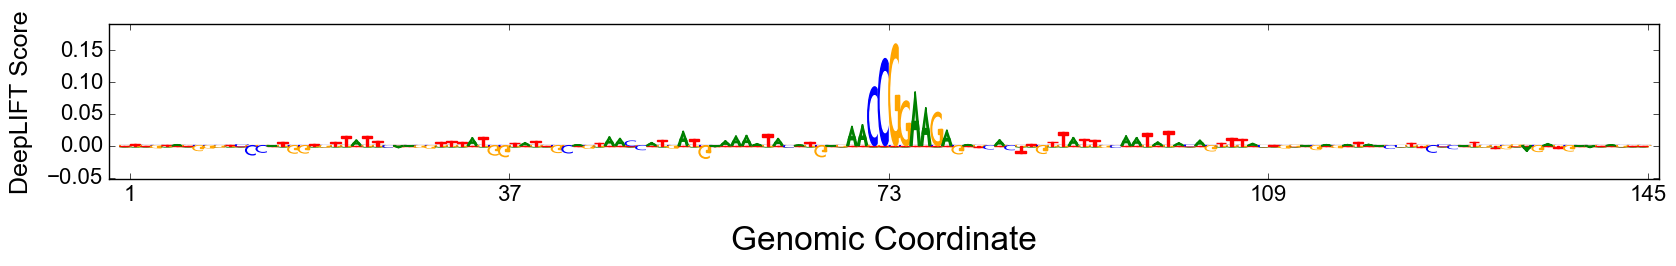

In [532]:
from deeplift.visualization import viz_sequence

# idxs = [779826, 788811, 814606, 733177, 31751, 324202]\
idxs = [779826]

for idx in idxs:
    print refPreds[idx, 8]
    print mutPreds[:, idx, 8]
    viz_sequence.plot_weights(task_to_deeplift_summedscores[8][idx],
                              tickcount=4)

In [535]:
print seqsMutated.shape

(4, 1000000, 145, 4)


In [543]:
idx = 779826

refPred = refPreds[idx, 8]

origSeq = seqs[idx]
saturationMutSeqs = np.ndarray(shape=(145, 4, 145, 4), dtype=np.int8)
for i in range(145):
    for j in range(4):
        seq = np.copy(origSeq)
        seq[i] = np.zeros(4)
        seq[i, j] = 1
        saturationMutSeqs[i, j] = seq
saturationMutSeqs = np.reshape(saturationMutSeqs, (-1, 145, 4))
saturationMutPreds = keras_model.predict(saturationMutSeqs, batch_size=200)
ismScores = np.transpose(np.reshape(saturationMutPreds[:, 8], (145, 4))) - refPred
print ismScores.shape

(4, 145)


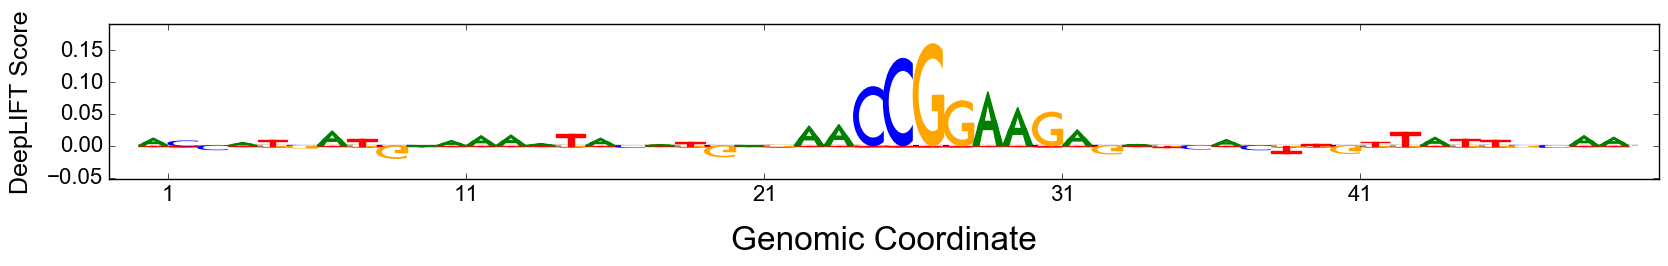

In [660]:
viz_sequence.plot_weights(task_to_deeplift_summedscores[8][idx][72-25 : 72+25],
                          tickcount=5,
                          save=True,
                          savepath='../plots/variant_scoring/deepliftTrack_50bp_%d' % idx,
                          dpi=300)

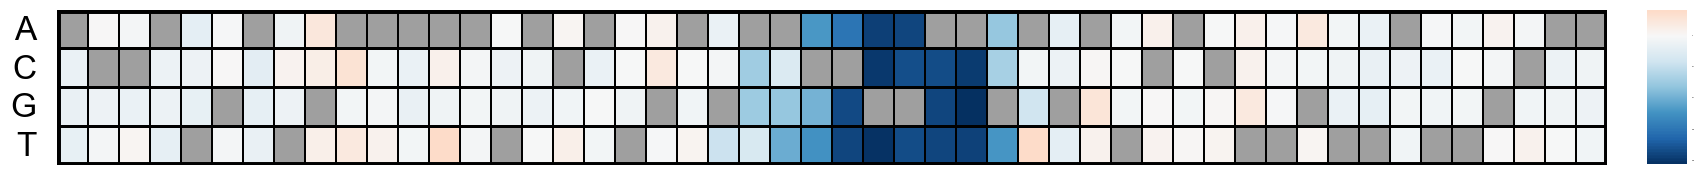

In [730]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(20, 2), dpi=300)

ax = fig.add_subplot(1, 1, 1)

cbar_ax = fig.add_axes([.92, 0.128, .02, 0.772])

ax = sns.heatmap(ismScores[:, 72-25 : 72+25], cmap = 'RdBu_r', center = 0,
                 lw = 1.2, linecolor = 'black',
                 ax = ax,
#                  robust = True,
                 cbar_ax = cbar_ax)

ax.add_patch(Rectangle((0, 0), 50, 4, fill=False, edgecolor='black', lw=5))

sns.heatmap(ismScores[:, 72-25 : 72+25], 
            mask = np.abs(ismScores[:, 72-25 : 72+25]) > 0, 
            cbar=False,
            cmap = sns.color_palette("RdGy", n_colors=3),
            lw = 1.2, linecolor = 'black',
            ax = ax)

# bases = ['a', 'c', 'g', 't']
# for (i, base) in enumerate(seqStrings[idx][72-25 : 72+25]):
#     h = bases.index(base)
#     if i == 0:
#         ax.add_patch(Rectangle((i+0.05, h + 0.012), 0.938, 0.976, fill=True, edgecolor='black', lw=0, facecolor='#CCCCCC'))
#     if base == 'a':
#         ax.add_patch(Rectangle((i+0.02, h+0.05), 0.96, 0.8, fill=True, edgecolor='black', lw=0, facecolor='#CCCCCC'))
#     if base == 't':
#         ax.add_patch(Rectangle((i+0.02, h+0.02), 0.96, 0.93, fill=True, edgecolor='black', lw=0, facecolor='#CCCCCC'))
#     ax.add_patch(Rectangle((i+0.012, h+0.012), 0.976, 0.976, fill=True, edgecolor='black', lw=0, facecolor='#CCCCCC'))

ax.set_xticks([])
ax.yaxis.set_ticks_position('none')
locs = [x + 0.55 for x in range(4)]
# ax.set_yticks(locs, ['A', 'C', 'G', 'T'], fontsize = 36, rotation = 0)
# plt.tick_params(axis='y', which='major', labelsize=36)
ax.set_yticks(locs)
ax.set_yticklabels(['A', 'C', 'G', 'T'])
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=24)

cbar_ax.set_frame_on(False)
cbar_ax.yaxis.set_ticks_position('none')
plt.setp(cbar_ax.get_yticklabels(), rotation=0, fontsize=0)
# plt.setp(ax.collections, linewidth = 10)

ax.tick_params(axis='y', which='major', pad=15)

plt.savefig('../plots/variant_scoring/ismTrack_50bp_shorter_linestyle_greyedout_%d' % idx, dpi = 600)
plt.show()

In [525]:
print seqStrings[779826]
print seqStrings[779826][62:82]

tttgtatgggtcccatggtgttattcaaggtttatggtattgcagtaaccatgatgaaaaatacatgagaaccggaagagatcacttgttattgcaatatacagtttactggagagataaccttcccatgtggagatgaatagca
acatgagaaccggaagagat


In [481]:
task_to_deeplift_summedscores[8][1956654][:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        , -0.        , -0.00092608, -0.        ],
       [-0.        , -0.        , -0.00025197, -0.        ],
       [ 0.00165053,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.00025478,  0.        ,  0.        ],
       [-0.        , -0.        , -0.        , -0.00641352],
       [ 0.        ,  0.00460546,  0.        ,  0.        ],
       [-0.        , -0.0021883 , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.0098759 ],
       [-0.        , -0.01111351, -0.        , -0.        ]], dtype=float32)

In [464]:
import inspect
print inspect.getargspec(viz_sequence.plot_weights)

ArgSpec(args=['array', 'figsize', 'height_padding_factor', 'length_padding', 'subticks_frequency', 'colors', 'plot_funcs', 'highlight', 'show', 'save', 'savepath', 'xlabel', 'ylabel', 'tickcount', 'xtickfontsize', 'ytickfontsize', 'start_coord', 'title', 'titlefontsize', 'xaxisfontsize', 'yaxisfontsize', 'xaxispad', 'yaxispad', 'titlepad', 'dpi'], varargs=None, keywords=None, defaults=((20, 2), 0.2, 1.0, 1.0, {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}, {0: <function plot_a at 0x7fad5eb49e60>, 1: <function plot_c at 0x7fad5eb5f578>, 2: <function plot_g at 0x7fad5eb5f8c0>, 3: <function plot_t at 0x7fad5eb5f938>}, {}, True, False, None, 'Genomic Coordinate', 'DeepLIFT Score', 20.0, 16, 16, None, None, 24, 24, 18, 15, 10, 15, 300))


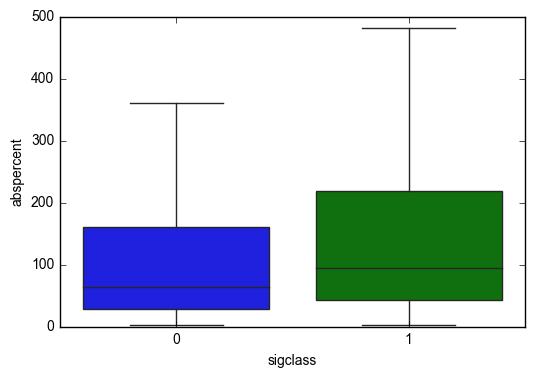

In [409]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.kdeplot(data = df[df['sigclass'] == 1]['absscore'])
# sns.kdeplot(data = df[df['sigclass'] == 0]['absscore'])
ax = sns.boxplot(data = df[df['sigclass'] >= 0], y = 'abspercent', x = 'sigclass', fliersize=0)

ax.set_ylim(0, 500)

plt.show()

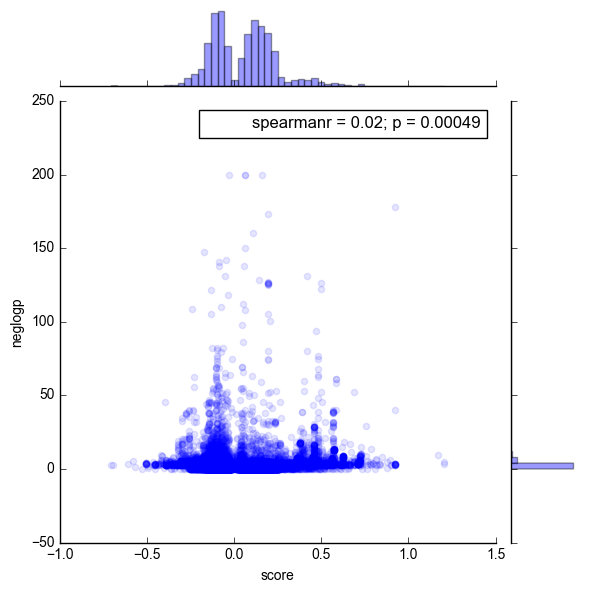

In [380]:
from scipy.stats import spearmanr

sns.jointplot(data = df[df['volcanoend'] == True], x = 'score', y = 'neglogp', stat_func = spearmanr, alpha = 0.1)

plt.show()